In [13]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt


In [14]:
path = 'energydata/*.csv'
csv_files = glob.glob(path)
csv_files
dfs = []

for file in csv_files:
    base = os.path.basename(file)
    date_str = base.replace('OVO Electricity Use ', '').replace('.csv', '')
    try:
        file_date = datetime.strptime(date_str, '%d-%m-%Y').date()
    except ValueError as e:
        print(f"Error parsing date from file name {file}: {e}")
        continue

    try:
        df = pd.read_csv(file)
        df['datetime'] = pd.to_datetime(df['Time'].apply(lambda x: datetime.combine(file_date, datetime.strptime(x, '%H:%M').time())))
        df.drop('Time', axis=1, inplace=True)
        dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

if not dfs:
    raise ValueError("No dataframes were created. Check if the CSV files are correctly read.")
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.sort_values(by='datetime', inplace=True)
first_column = combined_df.pop('datetime')
combined_df.insert(0, 'datetime', first_column)

combined_df.to_csv('combined_energy_usage.csv', index=False)

In [15]:
energy_df= pd.read_csv('combined_energy_usage.csv')
energy_df['datetime'] = pd.to_datetime(energy_df['datetime'])
energy_df

,datetime,Consumption (kWh)
0,2023-11-01 00:00:00,0.02
1,2023-11-01 00:30:00,0.03
2,2023-11-01 01:00:00,0.01
3,2023-11-01 01:30:00,0.35
4,2023-11-01 02:00:00,0.01
...,...,...
1387,2023-11-29 21:30:00,1.02
1388,2023-11-29 22:00:00,1.25
1389,2023-11-29 22:30:00,0.46
1390,2023-11-29 23:00:00,0.78


In [16]:
weather_df=pd.read_csv('sheffield 2023-11-01 to 2023-11-29.csv')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
columns_to_drop = ['name','preciptype','severerisk','stations','visibility','snowdepth','snow','conditions', 'icon']
weather_df = weather_df.drop(columns=columns_to_drop)

In [47]:
sensor_df= pd.read_csv('sensor_data.csv')
sensor_df.rename(columns={'2023-11-02 19:01:56': 'datetime',
                   '26.968833923339844': 'sensor_temp', '0': 'pressure','53.382083892822266':"humidity"},
          inplace=True, errors='raise')
sensor_df=sensor_df.dropna()
sensor_df['datetime'] = pd.to_datetime(sensor_df['datetime'])
sensor_df.set_index('datetime', inplace=True)
sensor_df = sensor_df[~sensor_df.index.duplicated(keep='first')]

# Resampling the data on an hourly basis using 'nearest' method
hourly_sensor_df = sensor_df.resample('H').nearest(limit=1).reset_index()

hourly_sensor_df = hourly_sensor_df.dropna()
hourly_sensor_df

,datetime,sensor_temp,pressure,humidity
0,2023-11-02 19:00:00,26.968834,965.812500,52.830059
1,2023-11-02 20:00:00,33.118465,966.383789,42.068321
2,2023-11-02 21:00:00,21.016420,0.000000,73.839775
5,2023-11-03 00:00:00,22.432808,972.110352,71.352936
6,2023-11-03 01:00:00,35.682304,972.263428,36.865082
...,...,...,...,...
782,2023-12-05 09:00:00,43.140751,1009.530762,-44.982086
783,2023-12-05 10:00:00,23.988346,1010.366699,-3.858952
784,2023-12-05 11:00:00,23.796522,1011.066650,0.000005
785,2023-12-05 12:00:00,28.248697,887.827881,-7.934053


In [48]:
energy_weather_df = pd.merge(energy_df, weather_df, on='datetime', how='left')
energy_weather_df = pd.merge(energy_weather_df, hourly_sensor_df, on='datetime', how='left')
energy_weather_df=energy_weather_df.dropna()
energy_weather_df.to_csv('energy_weather_dataset.csv', index=False)
energy_weather_df

,datetime,Consumption (kWh),temp,feelslike,dew,humidity_x,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,sensor_temp,pressure,humidity_y
86,2023-11-02 19:00:00,0.04,8.5,5.3,8.1,97.65,1.288,100.0,31.6,21.5,295.0,970.2,100.0,0.0,0.0,0.0,26.968834,965.812500,52.830059
88,2023-11-02 20:00:00,0.39,8.4,4.9,7.7,95.34,0.451,100.0,36.3,24.3,290.0,971.1,100.0,0.0,0.0,0.0,33.118465,966.383789,42.068321
90,2023-11-02 21:00:00,0.03,8.3,4.8,7.4,94.15,0.174,100.0,41.1,25.4,288.0,971.9,100.0,0.0,0.0,0.0,21.016420,0.000000,73.839775
96,2023-11-03 00:00:00,0.03,7.9,4.3,7.1,94.51,0.123,100.0,40.3,25.4,279.0,973.8,100.0,0.0,0.0,0.0,22.432808,972.110352,71.352936
98,2023-11-03 01:00:00,0.22,7.7,4.0,6.8,93.96,0.035,100.0,42.5,25.3,275.0,974.3,100.0,0.0,0.0,0.0,35.682304,972.263428,36.865082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,2023-11-29 19:00:00,0.15,-1.7,-4.3,-2.9,91.51,0.000,0.0,8.2,6.6,342.0,1004.4,49.7,0.0,0.0,0.0,80.235756,1002.937500,22.362144
1384,2023-11-29 20:00:00,0.88,-1.6,-4.6,-2.9,91.05,0.000,0.0,9.9,7.9,312.0,1004.3,29.2,0.0,0.0,0.0,39.967327,1002.954590,22.944231
1386,2023-11-29 21:00:00,1.82,-1.9,-4.6,-3.2,90.38,0.000,0.0,8.8,7.2,335.0,1004.2,68.4,0.0,0.0,0.0,25.401258,1003.002930,-75388.500000
1388,2023-11-29 22:00:00,1.25,-1.8,-4.5,-3.4,89.10,0.000,0.0,9.5,7.0,335.0,1004.1,37.8,0.0,0.0,0.0,39.357742,3715.917725,25.759008


In [49]:
def is_midnight(row):
    return 0 <= row.hour < 5

energy_weather_df['midnight_flag'] = energy_weather_df['datetime'].apply(is_midnight)
energy_weather_df

,datetime,Consumption (kWh),temp,feelslike,dew,humidity_x,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,sensor_temp,pressure,humidity_y,midnight_flag
86,2023-11-02 19:00:00,0.04,8.5,5.3,8.1,97.65,1.288,100.0,31.6,21.5,295.0,970.2,100.0,0.0,0.0,0.0,26.968834,965.812500,52.830059,False
88,2023-11-02 20:00:00,0.39,8.4,4.9,7.7,95.34,0.451,100.0,36.3,24.3,290.0,971.1,100.0,0.0,0.0,0.0,33.118465,966.383789,42.068321,False
90,2023-11-02 21:00:00,0.03,8.3,4.8,7.4,94.15,0.174,100.0,41.1,25.4,288.0,971.9,100.0,0.0,0.0,0.0,21.016420,0.000000,73.839775,False
96,2023-11-03 00:00:00,0.03,7.9,4.3,7.1,94.51,0.123,100.0,40.3,25.4,279.0,973.8,100.0,0.0,0.0,0.0,22.432808,972.110352,71.352936,True
98,2023-11-03 01:00:00,0.22,7.7,4.0,6.8,93.96,0.035,100.0,42.5,25.3,275.0,974.3,100.0,0.0,0.0,0.0,35.682304,972.263428,36.865082,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,2023-11-29 19:00:00,0.15,-1.7,-4.3,-2.9,91.51,0.000,0.0,8.2,6.6,342.0,1004.4,49.7,0.0,0.0,0.0,80.235756,1002.937500,22.362144,False
1384,2023-11-29 20:00:00,0.88,-1.6,-4.6,-2.9,91.05,0.000,0.0,9.9,7.9,312.0,1004.3,29.2,0.0,0.0,0.0,39.967327,1002.954590,22.944231,False
1386,2023-11-29 21:00:00,1.82,-1.9,-4.6,-3.2,90.38,0.000,0.0,8.8,7.2,335.0,1004.2,68.4,0.0,0.0,0.0,25.401258,1003.002930,-75388.500000,False
1388,2023-11-29 22:00:00,1.25,-1.8,-4.5,-3.4,89.10,0.000,0.0,9.5,7.0,335.0,1004.1,37.8,0.0,0.0,0.0,39.357742,3715.917725,25.759008,False


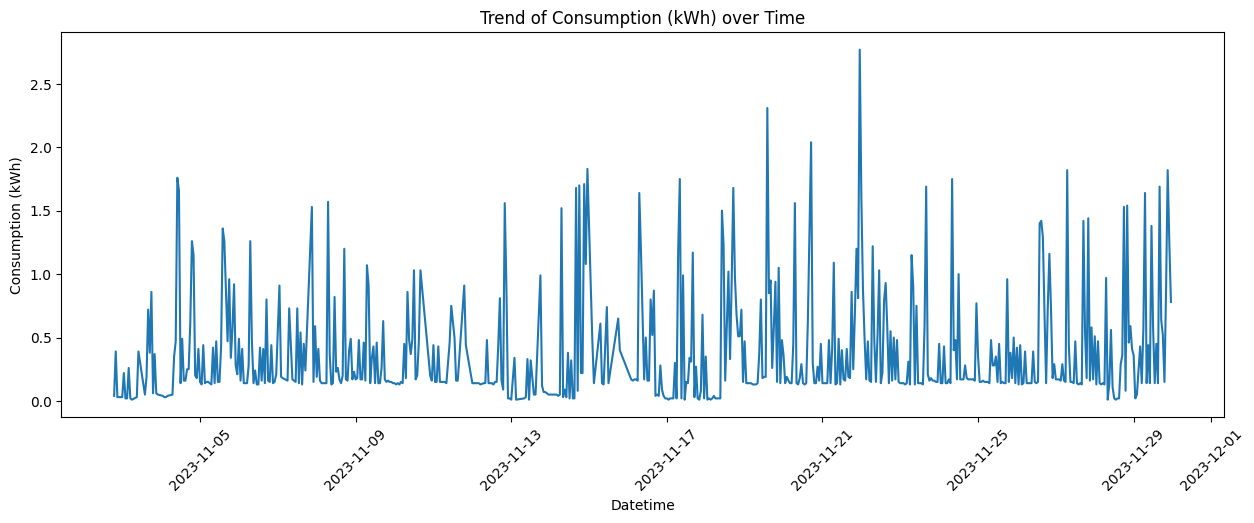

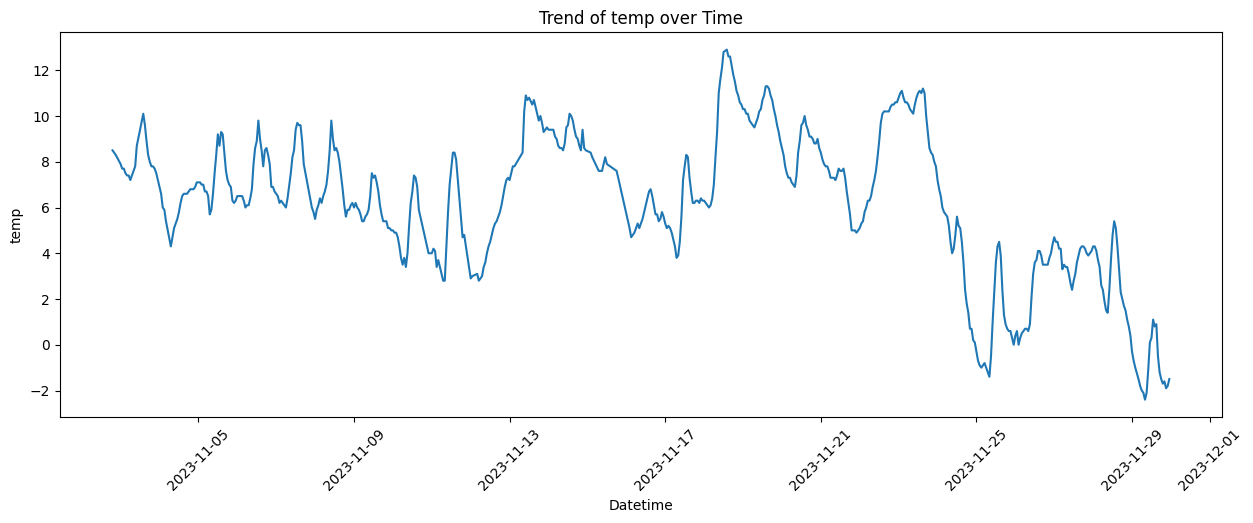

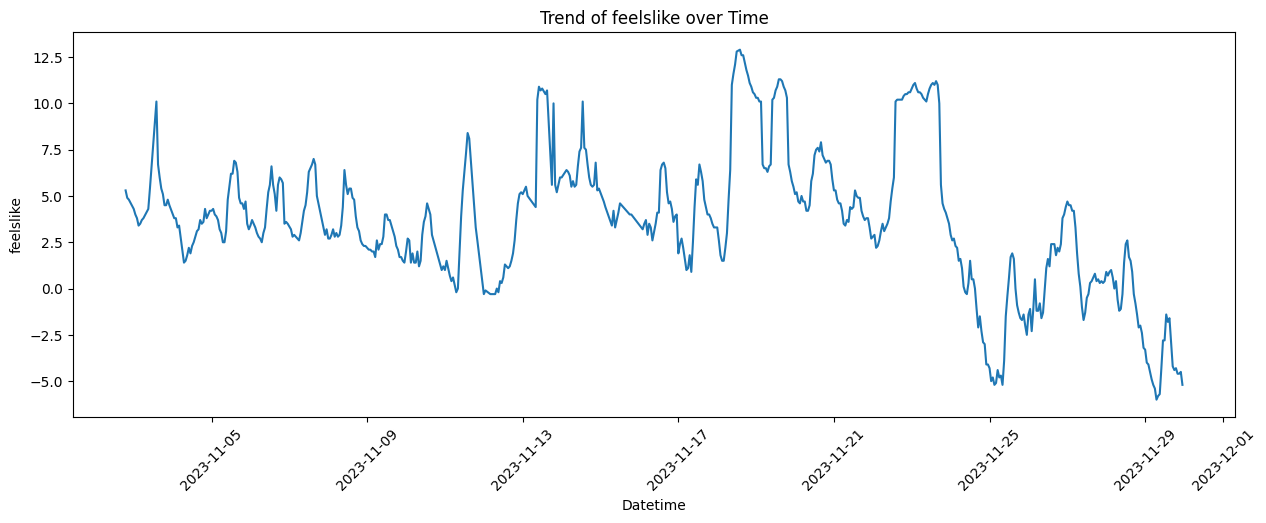

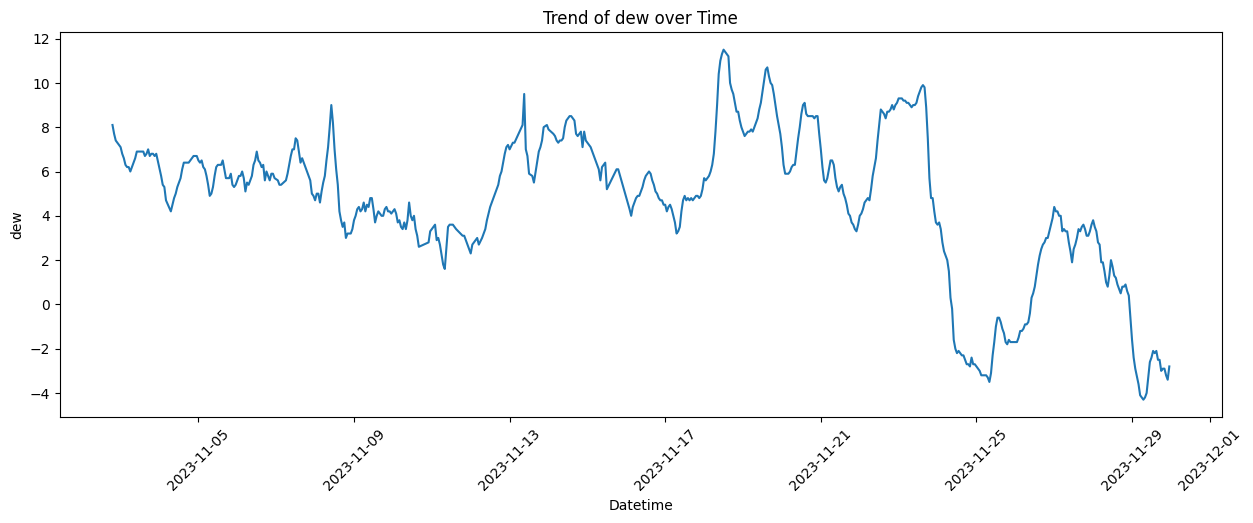

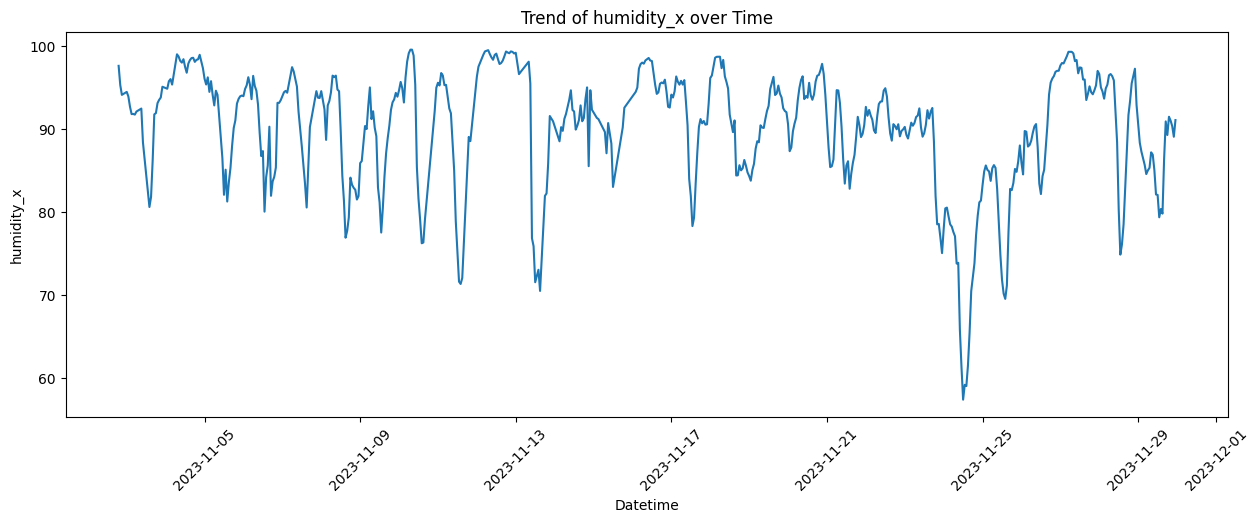

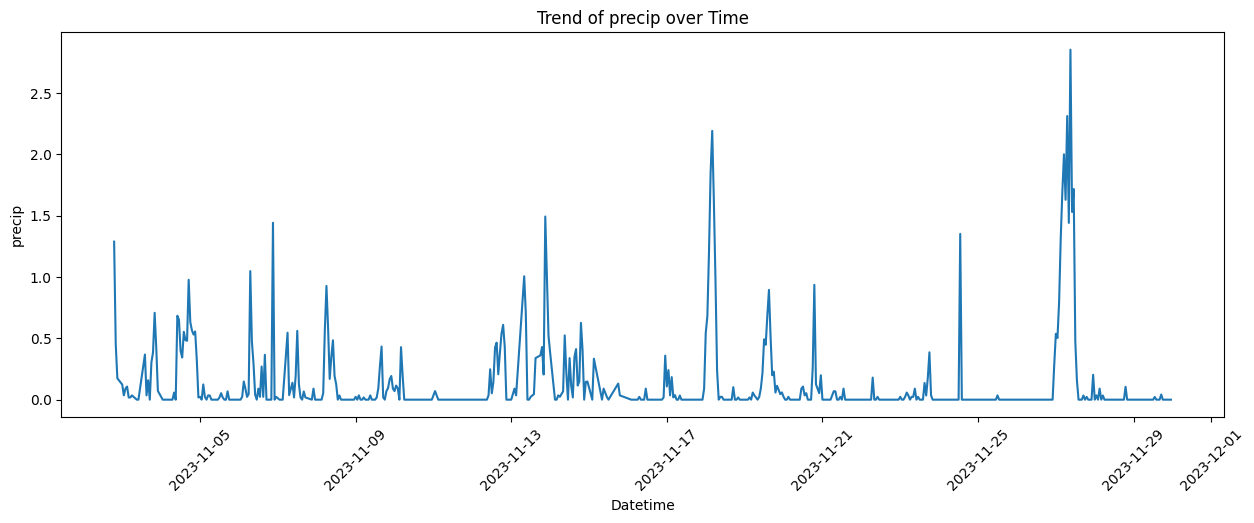

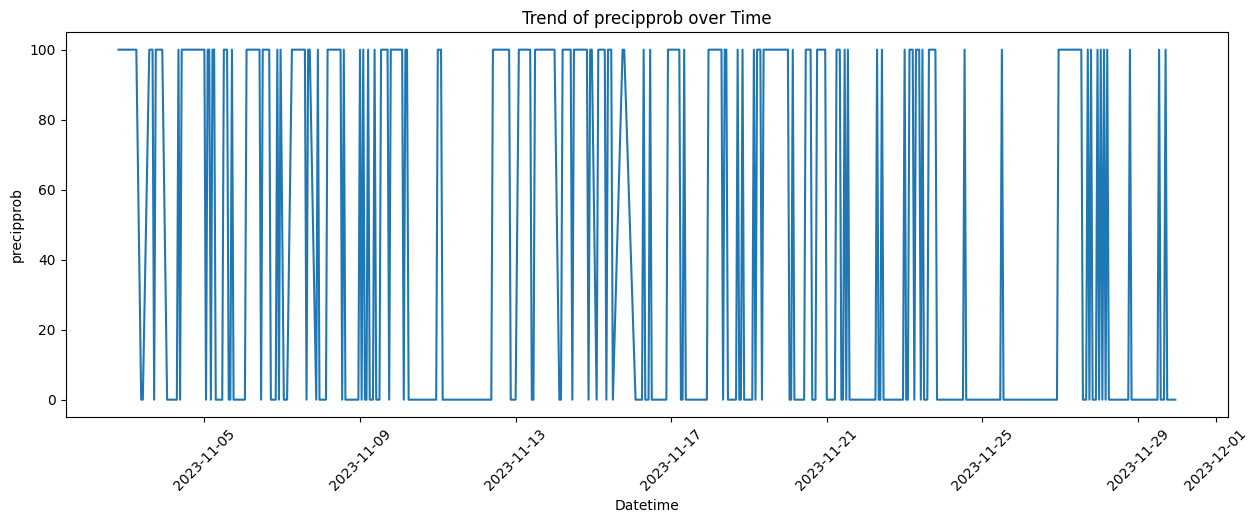

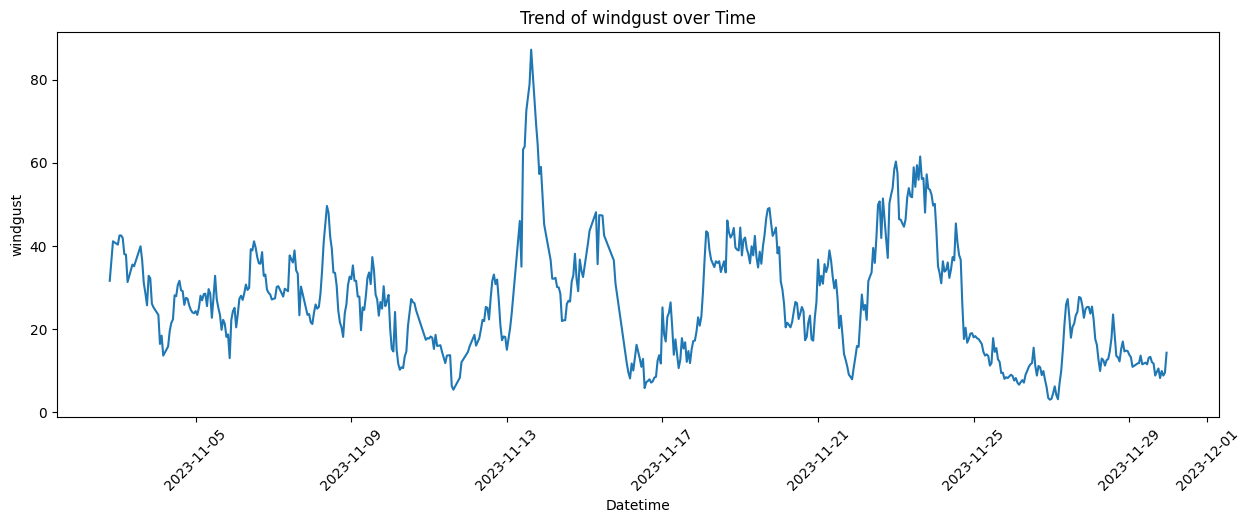

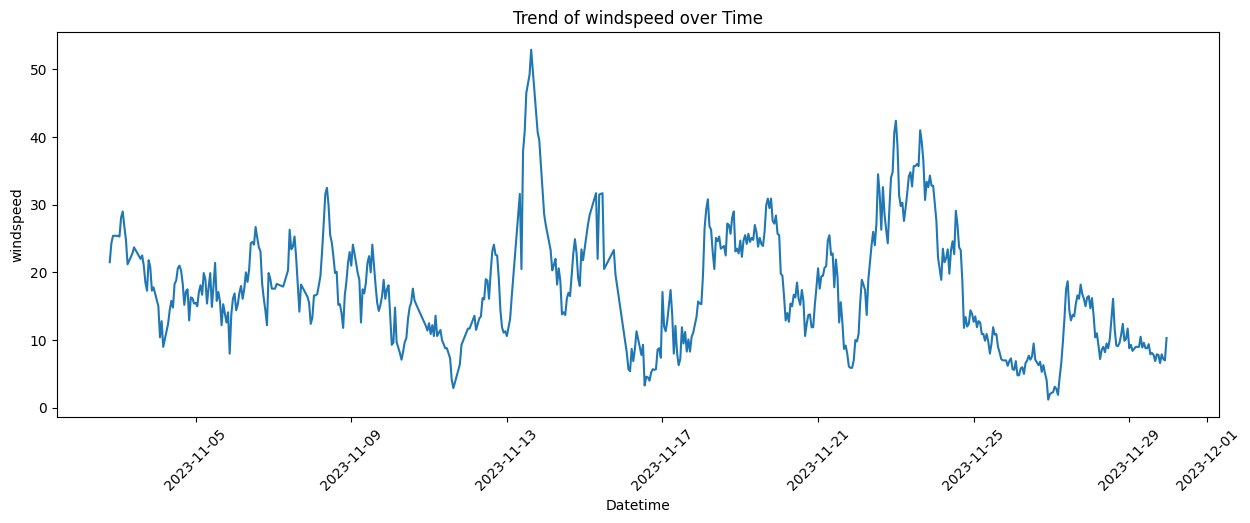

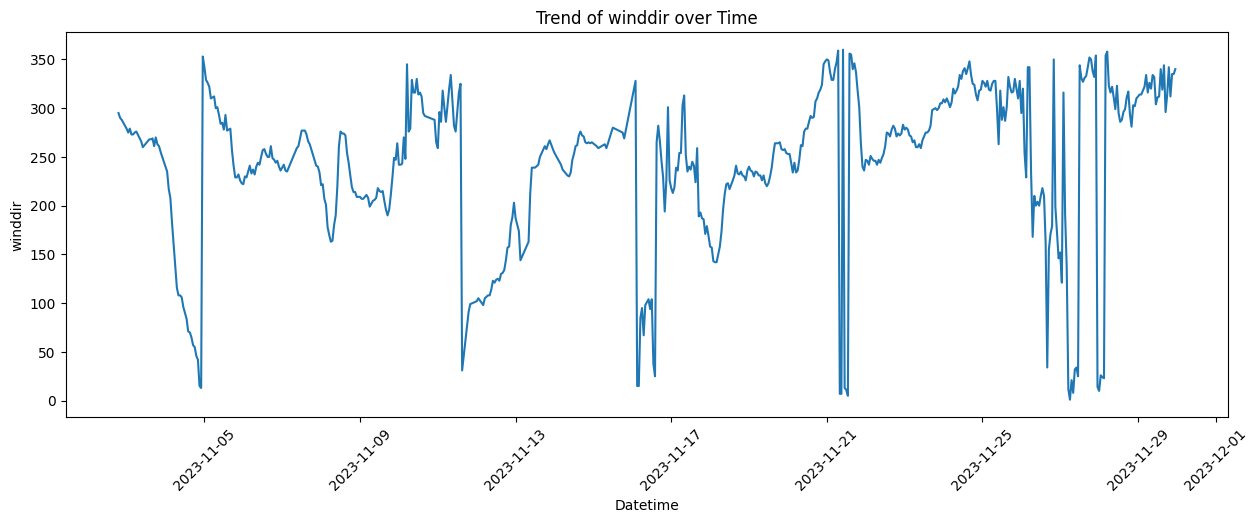

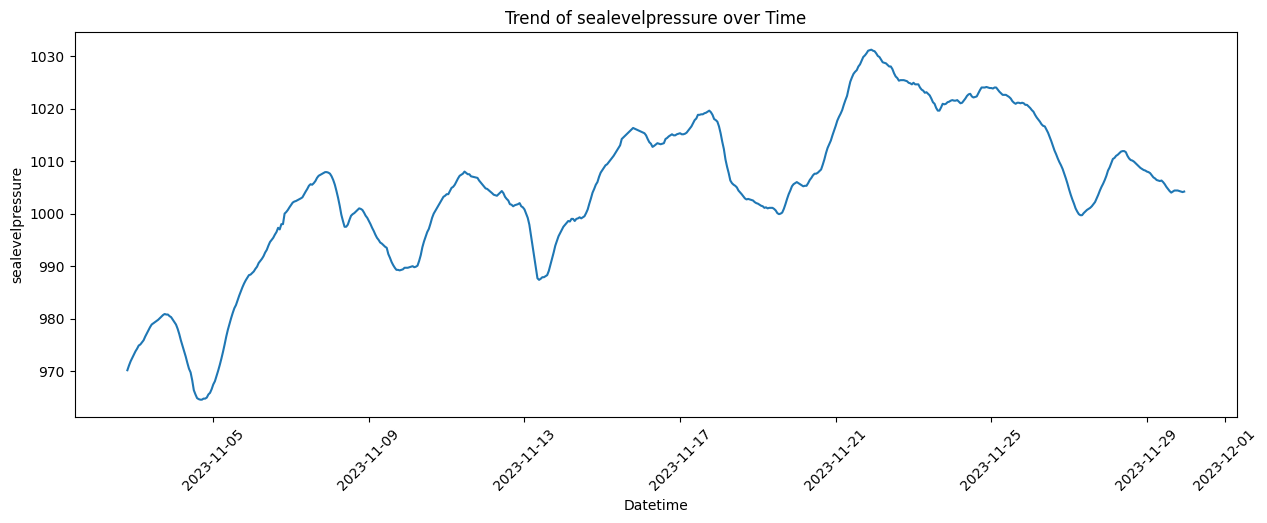

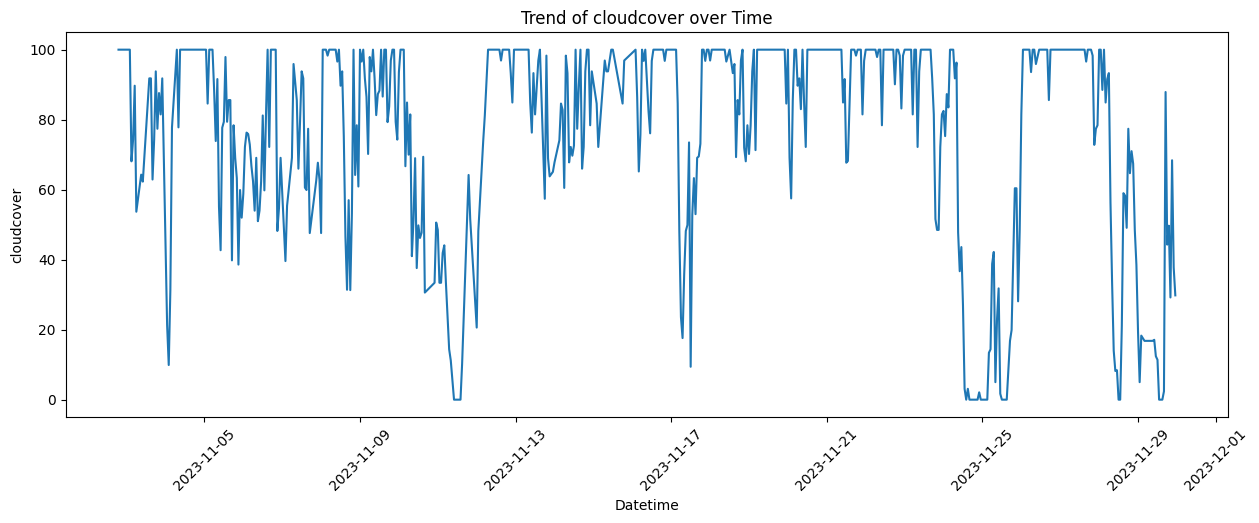

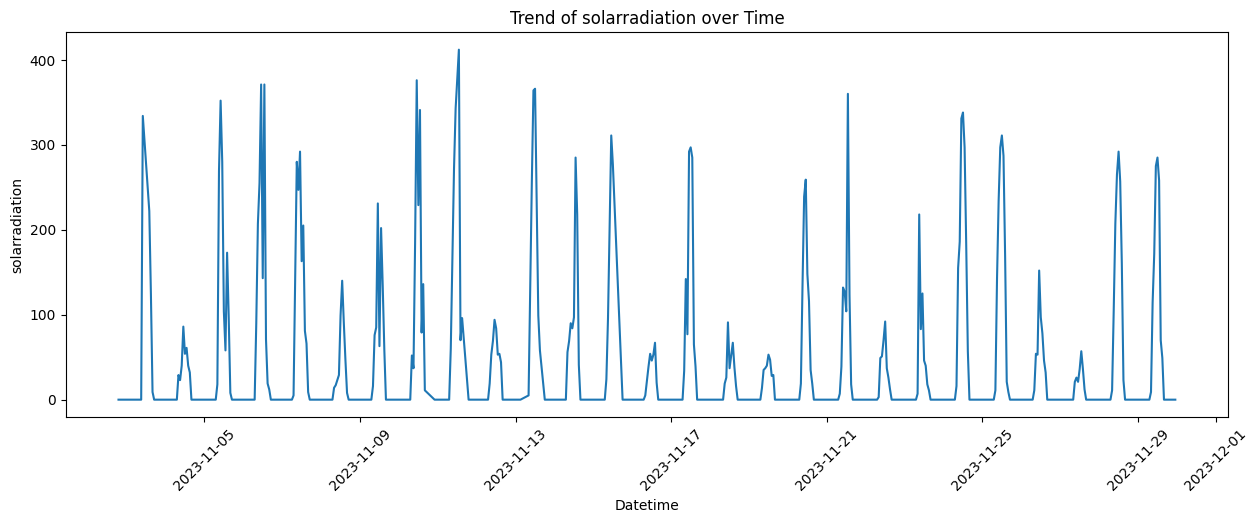

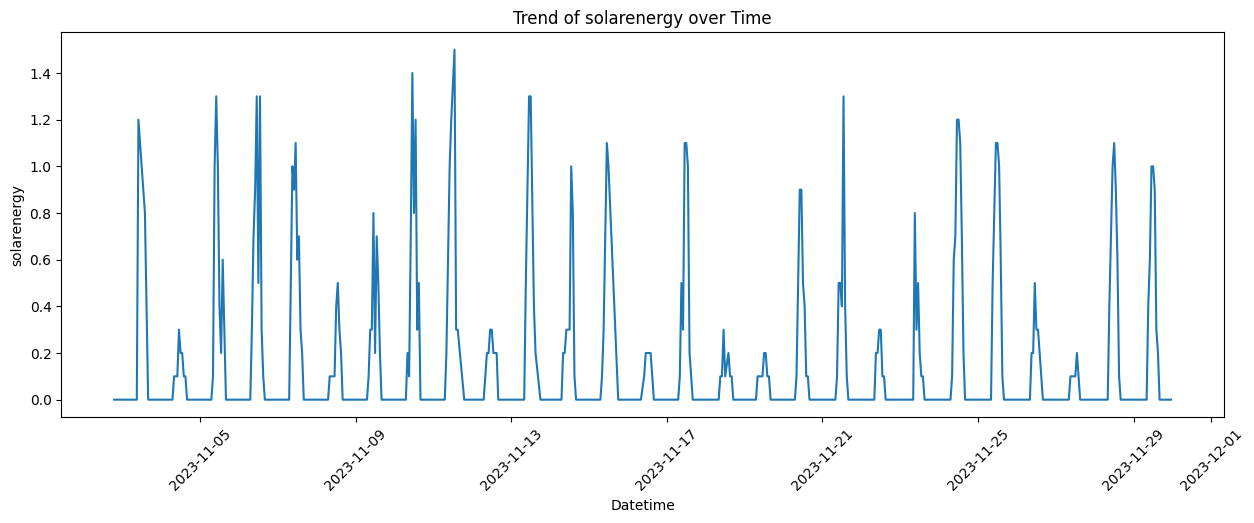

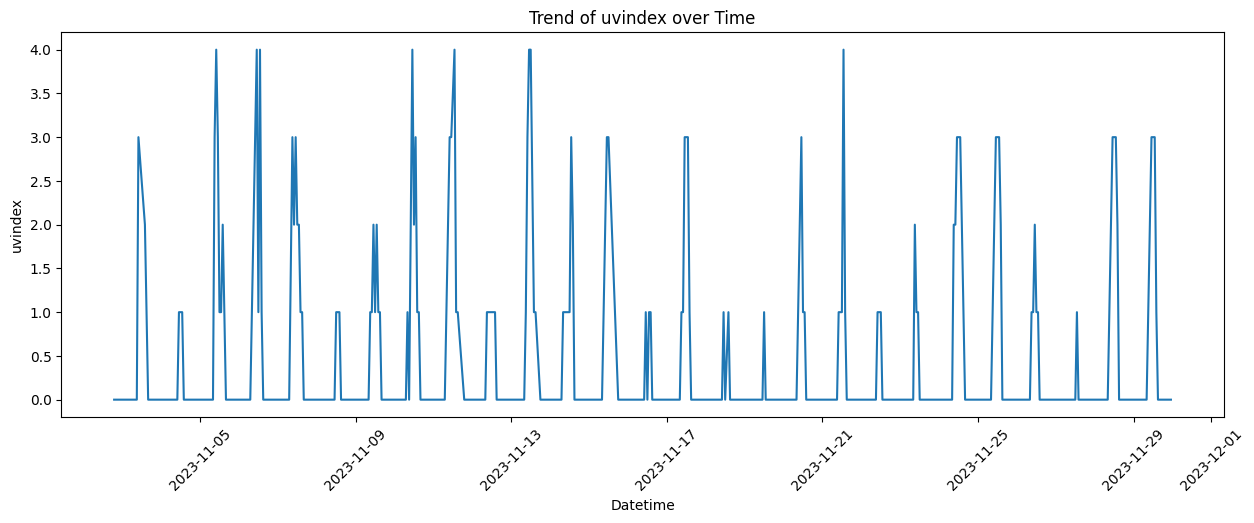

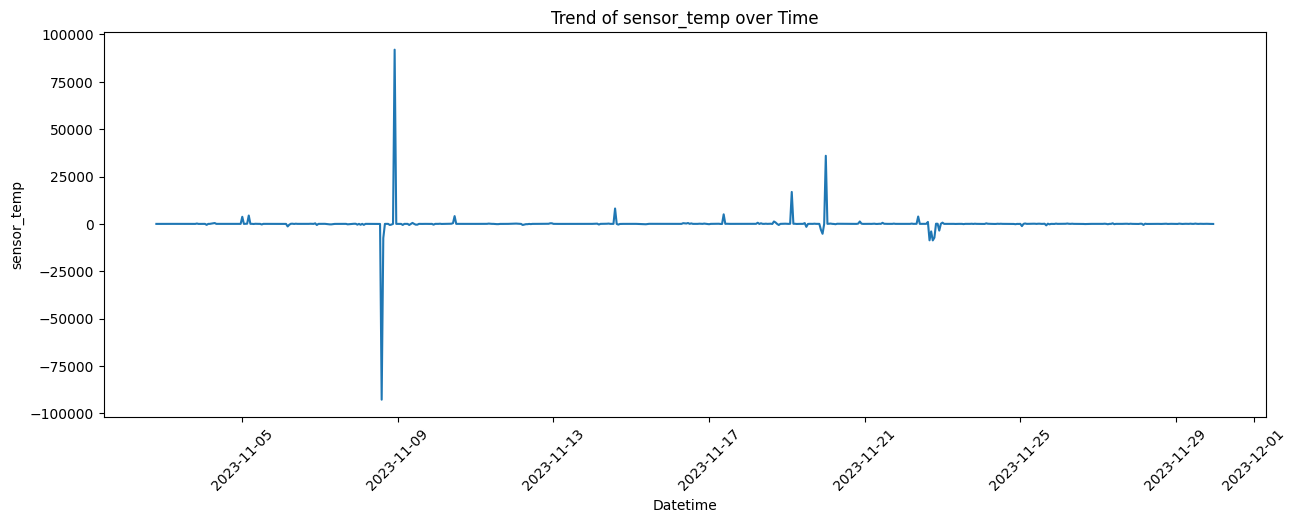

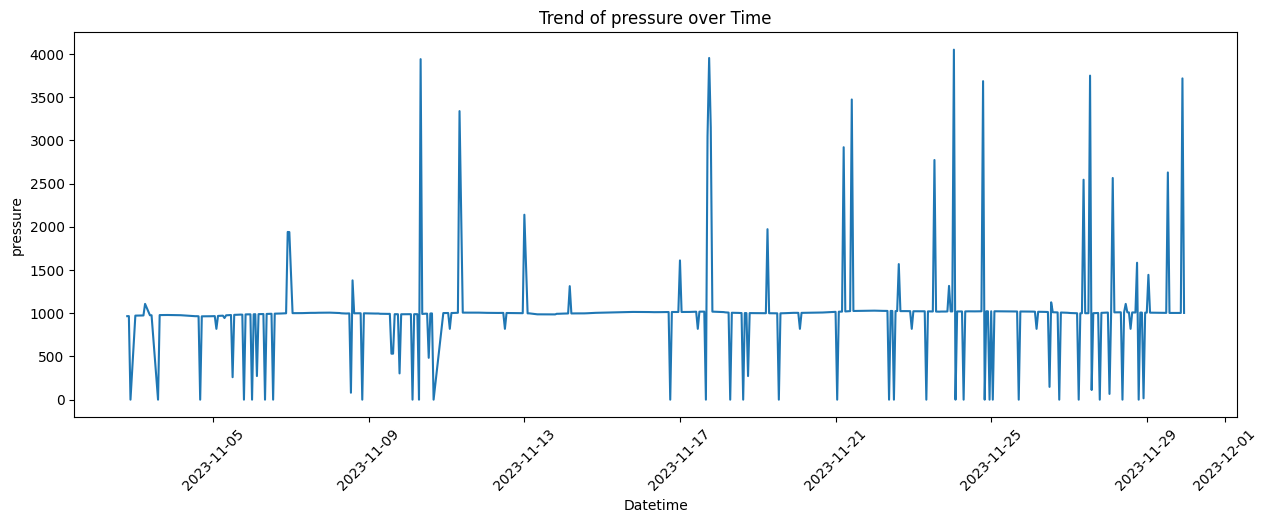

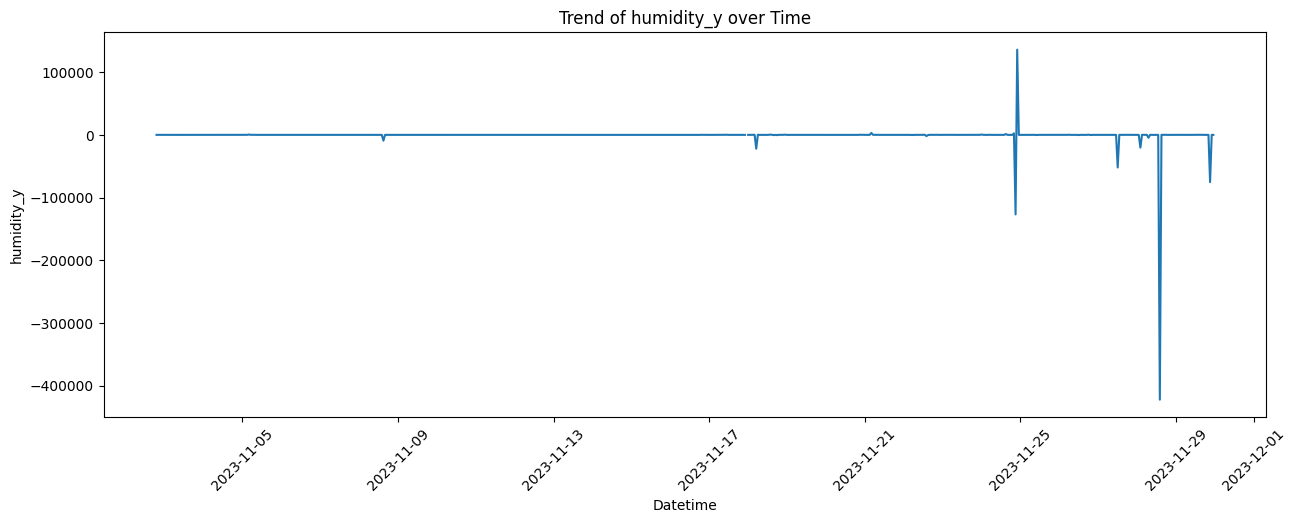

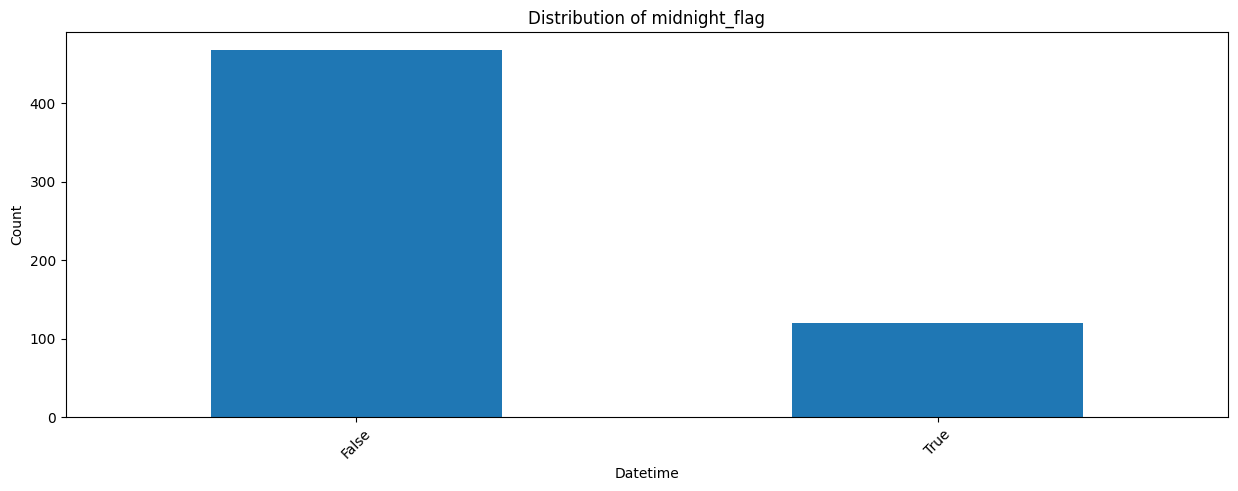

In [50]:

for column in energy_weather_df.columns:
    if column != 'datetime':
        plt.figure(figsize=(15, 5))

        if column in ['midnight_flag', 'icon']:
            energy_weather_df[column].value_counts().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.ylabel('Count')
        else:
            plt.plot(energy_weather_df['datetime'], energy_weather_df[column])
            plt.title(f'Trend of {column} over Time')
            plt.ylabel(column)
        
        plt.xlabel('Datetime')
        plt.xticks(rotation=45) 
        plt.show()

In [51]:
energy_weather_df

,datetime,Consumption (kWh),temp,feelslike,dew,humidity_x,precip,precipprob,windgust,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,sensor_temp,pressure,humidity_y,midnight_flag
86,2023-11-02 19:00:00,0.04,8.5,5.3,8.1,97.65,1.288,100.0,31.6,21.5,295.0,970.2,100.0,0.0,0.0,0.0,26.968834,965.812500,52.830059,False
88,2023-11-02 20:00:00,0.39,8.4,4.9,7.7,95.34,0.451,100.0,36.3,24.3,290.0,971.1,100.0,0.0,0.0,0.0,33.118465,966.383789,42.068321,False
90,2023-11-02 21:00:00,0.03,8.3,4.8,7.4,94.15,0.174,100.0,41.1,25.4,288.0,971.9,100.0,0.0,0.0,0.0,21.016420,0.000000,73.839775,False
96,2023-11-03 00:00:00,0.03,7.9,4.3,7.1,94.51,0.123,100.0,40.3,25.4,279.0,973.8,100.0,0.0,0.0,0.0,22.432808,972.110352,71.352936,True
98,2023-11-03 01:00:00,0.22,7.7,4.0,6.8,93.96,0.035,100.0,42.5,25.3,275.0,974.3,100.0,0.0,0.0,0.0,35.682304,972.263428,36.865082,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,2023-11-29 19:00:00,0.15,-1.7,-4.3,-2.9,91.51,0.000,0.0,8.2,6.6,342.0,1004.4,49.7,0.0,0.0,0.0,80.235756,1002.937500,22.362144,False
1384,2023-11-29 20:00:00,0.88,-1.6,-4.6,-2.9,91.05,0.000,0.0,9.9,7.9,312.0,1004.3,29.2,0.0,0.0,0.0,39.967327,1002.954590,22.944231,False
1386,2023-11-29 21:00:00,1.82,-1.9,-4.6,-3.2,90.38,0.000,0.0,8.8,7.2,335.0,1004.2,68.4,0.0,0.0,0.0,25.401258,1003.002930,-75388.500000,False
1388,2023-11-29 22:00:00,1.25,-1.8,-4.5,-3.4,89.10,0.000,0.0,9.5,7.0,335.0,1004.1,37.8,0.0,0.0,0.0,39.357742,3715.917725,25.759008,False
